##  Variational Autoencoder


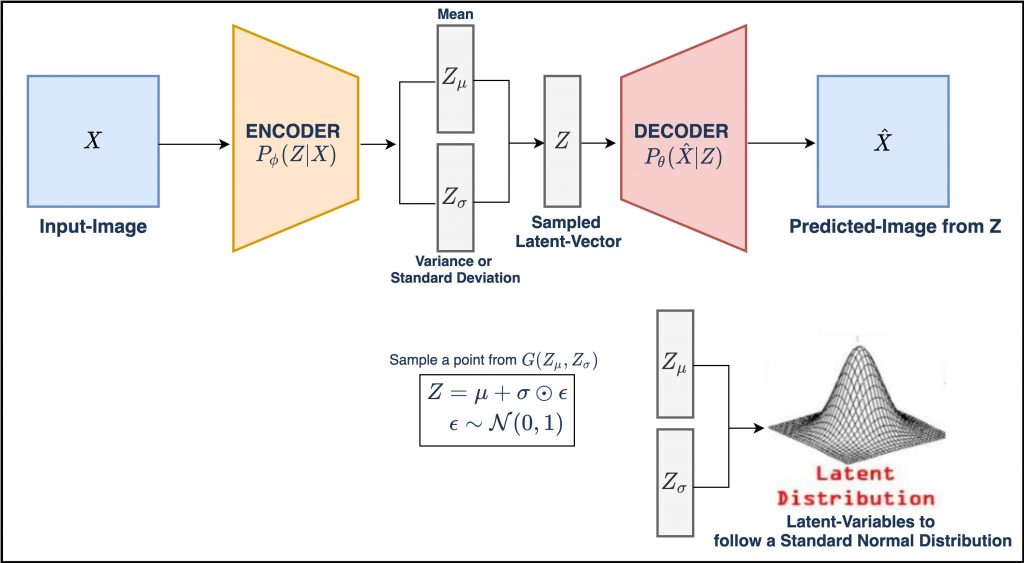

Variational Autoencoder ( VAE ) came into existence in 2013, when Diederik et al. published a paper Auto-Encoding Variational Bayes. This paper was an extension of the original idea of Auto-Encoder primarily to learn the useful distribution of the data. Variational Autoencoder was inspired by the methods of the variational bayesian and graphical model. VAE is rooted in Bayesian inference, i.e., it wants to model the underlying probability distribution of data to sample new data from that distribution.

VAE has one fundamentally unique property that separates them from vanilla autoencoder, and it is this property that makes them so useful for generative modeling: their latent spaces are, by design, continuous, allowing easy random sampling and interpolation.

__The main takeways poin about VAE__
- dimensionality reduction is the process of reducing the number of features that describe some data (either by selecting only a subset of the initial features or by combining them into a reduced number new features) and, so, can be seen as an encoding process
- autoencoders are neural networks architectures composed of both an encoder and a decoder that create a bottleneck to go through for data and that are trained to lose a minimal quantity of information during the encoding-decoding process (training by gradient descent iterations with the goal to reduce the reconstruction error)
- due to overfitting, the latent space of an autoencoder can be extremely irregular (close points in latent space can give very different decoded data, some point of the latent space can give meaningless content once decoded, …) and, so, we can’t really define a generative process that simply consists to sample a point from the latent space and make it go through the decoder to get a new data
- variational autoencoders (VAEs) are autoencoders that tackle the problem of the latent space irregularity by making the encoder return a distribution over the latent space instead of a single point and by adding in the loss function a regularisation term over that returned distribution in order to ensure a better organisation of the latent space
assuming a simple underlying probabilistic model to describe our data, the pretty intuitive loss function of VAEs, composed of a reconstruction term and a regularisation term, can be carefully derived, using in particular the statistical technique of variational inference (hence the name “variational” autoencoders)

## Loading and Preprocessing Dataset

In [71]:
import tensorflow as tf
import numpy
import matplotlib.pyplot
from tensorflow.keras.layers import Input,Conv2D,BatchNormalization,LeakyReLU,Dense,Reshape,Flatten,Lambda,Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.backend import random_normal,exp,int_shape,shape,mean

In [66]:
img_size = 28
num_channels = 1
latent_space_dim = 2

In [67]:
# Encoder
x = Input(shape=(img_size, img_size, num_channels), name="encoder_input")

encoder_conv_layer1 = Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = int_shape(encoder_activ_layer5)[1:]
encoder_flatten = Flatten()(encoder_activ_layer5)

encoder_mu = Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")



In [68]:
def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = random_normal(shape=shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + exp(log_variance/2) * epsilon
    return random_sample

In [69]:
encoder_output = Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = Model(x, encoder_output, name="encoder_model")
encoder.summary()

Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 28, 28, 1)    10          encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_norm_1 (BatchNormalizat (None, 28, 28, 1)    4           encoder_conv_1[0][0]             
__________________________________________________________________________________________________
encoder_leakyrelu_1 (LeakyReLU) (None, 28, 28, 1)    0           encoder_norm_1[0][0]             
______________________________________________________________________________________

## Building the Decoder

In [72]:
decoder_input = Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_layer1 = Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)

decoder_conv_tran_layer1 = Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = Conv2DTranspose(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )

decoder = Model(decoder_input, decoder_output, name="decoder_model")
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_dense_1 (Dense)      (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_tran_1 (Conv2DT (None, 7, 7, 64)          36928     
_________________________________________________________________
decoder_norm_1 (BatchNormali (None, 7, 7, 64)          256       
_________________________________________________________________
decoder_leakyrelu_1 (LeakyRe (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_tran_2 (Conv2DT (None, 14, 14, 64)      

In [73]:
vae_input = Input(shape=(img_size, img_size, num_channels), name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = Model(vae_input, vae_decoder_output, name="VAE")
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VAE_input (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_model (Functional)   (None, 2)                 106130    
_________________________________________________________________
decoder_model (Functional)   (None, 28, 28, 1)         121537    
Total params: 227,667
Trainable params: 226,833
Non-trainable params: 834
_________________________________________________________________


In [87]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [88]:
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=loss_func(encoder_mu, encoder_log_variance))

In [89]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [90]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [91]:
x_train = numpy.reshape(x_train, newshape=(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = numpy.reshape(x_test, newshape=(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1))

In [92]:
vae.fit(x_train, x_train, epochs=20, batch_size=32, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/20
1875/1875 [==============================] - 377s 200ms/step - loss: 44.5918 - val_loss: 41.2075
Epoch 2/20
1875/1875 [==============================] - 369s 197ms/step - loss: 39.1937 - val_loss: 37.3858
Epoch 3/20
1875/1875 [==============================] - 365s 195ms/step - loss: 37.9119 - val_loss: 36.5613
Epoch 4/20
1875/1875 [==============================] - 366s 195ms/step - loss: 37.0149 - val_loss: 39.6101
Epoch 5/20
1875/1875 [==============================] - 365s 195ms/step - loss: 36.2860 - val_loss: 37.4525
Epoch 6/20
1875/1875 [==============================] - 364s 194ms/step - loss: 35.7914 - val_loss: 35.5419
Epoch 7/20
1875/1875 [==============================] - 370s 197ms/step - loss: 35.3389 - val_loss: 35.0214
Epoch 8/20
1875/1875 [==============================] - 368s 196ms/step - loss: 35.0840 - val_loss: 34.9269
Epoch 9/20
1875/1875 [==============================] - 363s 193ms/step - loss: 34.8562 - val_loss: 35.0807
Epoch 10/20
1875/1875 [=====

In [98]:
predicted=vae.predict(np.array(x_test[10:20].reshape(-1, 28, 28, 1)))

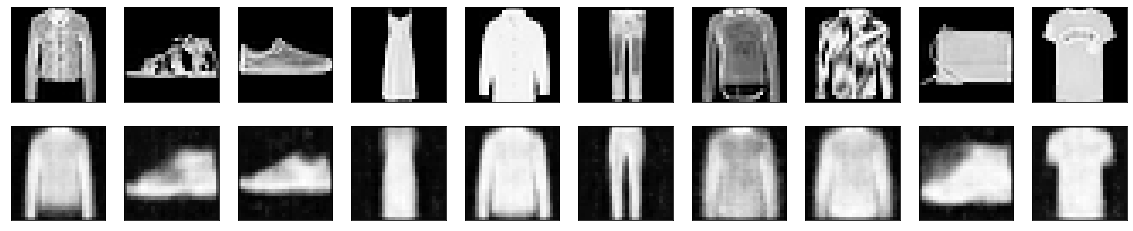

In [99]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([np.array(x_test[10:20]), predicted], axes):
      for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)